# MultiGroupRESIT
## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import random
import numpy as np
import pandas as pd
import graphviz
from IPython.display import display, HTML

from scipy.stats import norm, uniform
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import lingam
from lingam.hsic import hsic_test_gamma
from lingam.utils import make_prior_knowledge, make_dot

import warnings
warnings.filterwarnings('ignore')

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.4', '2.3.0', '0.20.3', '1.11.0']


In [2]:
np.set_printoptions(precision=3, suppress=True)
seed = 123
random.seed(seed)
np.random.seed(seed)

In [3]:
def test_causes(estimated, true):
    true = np.where(true > 0, 1, true)
    true = np.where(true < 0, -1, true)
    true = np.where(true == 0, 2, true)
    count_true = int(np.count_nonzero((true == 1) | (true == -1)))
    
    estimated = np.where(estimated > 0, 1, estimated)
    estimated = np.where(estimated < 0, -1, estimated)
    estimated = np.where(estimated == 0, -2, estimated)
    count_estimated = int(np.count_nonzero((estimated == 1) | (estimated == -1)))

    TP = int(np.count_nonzero(true == estimated))
    precision = 0 if count_estimated == 0 else TP / count_estimated
    recall = 0 if count_true == 0 else TP / count_true
    f_measure = 0 if precision+recall == 0 else 2*precision*recall/(precision+recall)
    
    return precision, recall, f_measure

In [4]:
def get_random_constant(s,b):
    constant = random.uniform(-1.0, 1.0)
    if constant>0:
        constant = random.uniform(s, b)
    else:
        constant = random.uniform(-b, -s)
    return constant

def get_noise(n):
    noise = ((np.random.rand(1, n)-0.5)*5).reshape(n)
    mean = get_random_constant(0.0,2.0)
    noise += mean
    return noise

def causal_func(cause):
    a = get_random_constant(-5.0,5.0)
    b = get_random_constant(-1.0,1.0)
    c = int(random.uniform(2,3))
    return ((cause+a)**(c))+b

def create_data(adjacency_matrix, n_samples=100):
    n_variables = adjacency_matrix.shape[0]
    causal_pairs = np.array(np.where(np.abs(adjacency_matrix) > 0))[[1, 0], :].T
    causal_pairs = tuple(map(tuple, causal_pairs))
    # print(f"causal_pairs: {causal_pairs}")
    data = np.zeros((n_samples, n_variables))

    for i in range(n_variables):
        data[:,i] = get_noise(n_samples)

    for i1 in range(n_variables):
        data[:,i1] = data[:,i1] / np.std(data[:,i1])
        for i2 in range(i1, n_variables):
            if (i1, i2) in causal_pairs:
                # print(f"x{i1} -> x{i2}")
                data[:,i2] += causal_func(data[:,i1])
        
    return data

## Test data
First, we generate a causal structure with 5 variables.

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0.]]


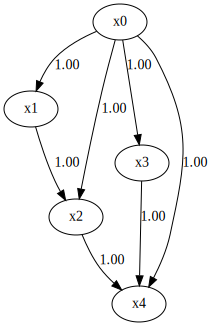

In [5]:
n_samples = 100
n_variables = 5
n_pairs = 7
causal_pairs = []
while len(causal_pairs) < n_pairs:
    xi = random.randint(0, n_variables - 1)
    xj = random.randint(0, n_variables - 1)
    if xi == xj:
        continue
    xi, xj = sorted([xi, xj])
    if not (xi, xj) in causal_pairs:
        causal_pairs.append((xi, xj))

true_graph = np.zeros([n_variables, n_variables])
for pair in causal_pairs:
    true_graph[pair[1], pair[0]] = 1

print(true_graph)
make_dot(true_graph)

We create a list variable that contains two datasets.

In [6]:
X1 = pd.DataFrame(create_data(true_graph, n_samples), columns=[f'x{i}' for i in range(n_variables)])
X2 = pd.DataFrame(create_data(true_graph, n_samples), columns=[f'x{i}' for i in range(n_variables)])
X3 = pd.DataFrame(create_data(true_graph, n_samples), columns=[f'x{i}' for i in range(n_variables)])
X_list = [X1, X2, X3]

## Causal Discovery
To run causal discovery for multiple datasets, we create a `MultiGroupRESIT` object and call the `fit()` method.

In [7]:
reg = RandomForestRegressor(max_depth=4, random_state=0)

model = lingam.MultiGroupRESIT(regressor=reg)
model.fit(X_list)

print(f"Causal Order={model.causal_order_}")
for i in range(3):
    precision, recall, f_measure = test_causes(model._adjacency_matrices[i], true_graph)
    print(f"Dataset #{i+1}\n  Precision={precision:.3f}\n  Recall={recall:.3f}\n  F-measure={f_measure:.3f}\n")

# Render both graphs as SVG strings
true_svg = make_dot(true_graph).pipe(format='svg').decode('utf-8')
svg1 = make_dot(model._adjacency_matrices[0]).pipe(format='svg').decode('utf-8')
svg2 = make_dot(model._adjacency_matrices[1]).pipe(format='svg').decode('utf-8')
svg3 = make_dot(model._adjacency_matrices[2]).pipe(format='svg').decode('utf-8')

# Display side by side using HTML
html = f"""
<div style="display: flex; gap: 40px; align-items: flex-start;">
  <div>
    <h3 style="text-align: center;">Ground Truth</h3>
    {true_svg}
  </div>
  <div>
    <h3 style="text-align: center;">Dataset #1</h3>
    {svg1}
  </div>
  <div>
    <h3 style="text-align: center;">Dataset #2</h3>
    {svg2}
  </div>
  <div>
    <h3 style="text-align: center;">Dataset #3</h3>
    {svg3}
  </div>
</div>
"""

display(HTML(html))

Causal Order=[0, 2, 4, 3, 1]
Dataset #1
  Precision=0.500
  Recall=0.429
  F-measure=0.462

Dataset #2
  Precision=0.800
  Recall=0.571
  F-measure=0.667

Dataset #3
  Precision=0.400
  Recall=0.286
  F-measure=0.333



To compare, we run `RESIT` with single dataset concatenating two datasets.

In [8]:
X_all = pd.concat([X1, X2, X3])
print(X_all.shape)

model = lingam.RESIT(regressor=reg)
model.fit(X_all)

print(f"Causal Order={model.causal_order_}")
precision, recall, f_measure = test_causes(model.adjacency_matrix_, true_graph)
print(f"Precision={precision:.3f}\nRecall={recall:.3f}\nF-measure={f_measure:.3f}\n")
svg = make_dot(model.adjacency_matrix_).pipe(format='svg').decode('utf-8')

# Display side by side using HTML
html = f"""
<div style="display: flex; gap: 40px; align-items: flex-start;">
  <div>
    <h3 style="text-align: center;">Ground Truth</h3>
    {true_svg}
  </div>
  <div>
    <h3 style="text-align: center;">Combined dataset</h3>
    {svg}
  </div>
</div>
"""

display(HTML(html))

(300, 5)
Causal Order=[3, 2, 4, 1, 0]
Precision=0.200
Recall=0.286
F-measure=0.235



Additionally, for comparison, run `RESIT` on each of the two datasets as a single dataset.

In [9]:
svg_list = []
for i in range(3):
    model = lingam.RESIT(regressor=reg).fit(X_list[i])
    print(f"Dataset #{i+1}")
    print(f"  Causal Order={model.causal_order_}")
    precision, recall, f_measure = test_causes(model.adjacency_matrix_, true_graph)
    print(f"  Precision={precision:.3f}\n  Recall={recall:.3f}\n  F-measure={f_measure:.3f}\n")
    svg = make_dot(model.adjacency_matrix_).pipe(format='svg').decode('utf-8')
    svg_list.append(svg)

# Display side by side using HTML
html = f"""
<div style="display: flex; gap: 40px; align-items: flex-start;">
  <div>
    <h3 style="text-align: center;">Ground Truth</h3>
    {true_svg}
  </div>
  <div>
    <h3 style="text-align: center;">Dataset #1</h3>
    {svg_list[0]}
  </div>
  <div>
    <h3 style="text-align: center;">Dataset #2</h3>
    {svg_list[1]}
  </div>
  <div>
    <h3 style="text-align: center;">Dataset #3</h3>
    {svg_list[2]}
  </div>
</div>
"""

display(HTML(html))

Dataset #1
  Causal Order=[0, 2, 3, 4, 1]
  Precision=0.750
  Recall=0.429
  F-measure=0.545

Dataset #2
  Causal Order=[4, 2, 0, 1, 3]
  Precision=0.167
  Recall=0.143
  F-measure=0.154

Dataset #3
  Causal Order=[1, 0, 3, 4, 2]
  Precision=0.500
  Recall=0.286
  F-measure=0.364

